# Estimation of correlation between (centroid offset, position-angle offset) and the $\Sigma$ values

**Author(s):** Muhammad Jobair Hasan, Sulyman Hossain, Ahmad Al - Imtiaz, S M Rafee Adnan, Anowar J. Shajib

## Uncertainty propagation and the pearson correlation coeffient ($r$)

We assume that the parameters (`"center_x_light"`, `"center_x_mass"`, `"center_y_light"`, `"center_y_mass"` , `"phi_light"`, `"phi_mass"`) conform to Gaussian distributions of means equaling the corresponding medians and the standard deviations equaling the corresponding averages (of the upper and the lower) $1\sigma$ uncertainties. These uncertainties propagate (through our calculations using the Euclidean distance formula, or otherwise) to the values of light and mass centeroid offsets, and the position-angle offset, $\Delta\phi$. We then use normal distributions having the calculated (uncertainties propagated) means and uncertainties (standard deviations) to sample from and calculate the biweight midcorrelation ($r_{bicorr}$) between the centeroid (and the position-angle offsets) and the $\Sigma$ values. By sampling multiple times and calculating the biweight midcorrelations ($r_{bicorr}$) we get a population of $r_{bicorr}$ values and thus calculate its mean, $1\sigma$ upper and $1\sigma$ lower uncertainties.

The four $\Sigma$ values we consider are:
- $\Sigma_{10}$
- $\Sigma_{10, \rm flux\ selected}$
- $\Sigma_{20}$
- $\Sigma_{20, \rm flux\ selected}$

## Relevant formulae for centroid offset


For the case of $f = aA + bB$, where A and B are two random variables and a, b are constants, we have $$\sigma_{f} = \sqrt{a^{2}\sigma_{A}^2 + b^{2}\sigma_{B}^2 - 2ab\sigma_{AB}}$$
In the case of independent A, B ($\sigma_{AB}=0$) and $a=b=1$ we have $$\sigma_{f} = \sqrt{\sigma_{A}^2 + \sigma_{B}^2}$$
We also have for independent A, B ($\sigma_{AB}=0$) and $f = \sqrt{A^{2}+B^{2}}$,
$$\sigma_{f} \approx \sqrt{\left(\frac{A}{f}\right)^{2}\sigma_{A}^{2} + \left(\frac{B}{f}\right)^{2}\sigma_{B}^{2}}$$

## Relevant formulae for position-angle offset

For the case of $f = aA + bB$, where A and B are two random variables and a, b are constants, we have $$\sigma_{f} = \sqrt{a^{2}\sigma_{A}^2 + b^{2}\sigma_{B}^2 - 2ab\sigma_{AB}}$$
In the case of independent A, B ($\sigma_{AB}=0$) and $a=b=1$ we have $$\sigma_{f} = \sqrt{\sigma_{A}^2 + \sigma_{B}^2}$$

## Import the necessary libraries

In [1]:
from statistics import mean

import astropy.units as u
import coloripy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import paperfig as pf
import seaborn as sns
import yaml
from astropy.cosmology import FlatLambdaCDM
from astropy.stats import biweight_midcorrelation
from numpy.random import normal

!pip install 'git+https://github.com/ajshajib/paperfig.git'
!pip install 'git+https://github.com/ajshajib/coloripy.git'
#!pip install astropy

  Cloning https://github.com/ajshajib/paperfig.git to /tmp/pip-req-build-bsju1h9u
  Running command git clone --filter=blob:none --quiet https://github.com/ajshajib/paperfig.git /tmp/pip-req-build-bsju1h9u
  Resolved https://github.com/ajshajib/paperfig.git to commit 7a0d34b2a87a6a15a209aaa63c81278a8f3ef8b1
  Preparing metadata (setup.py) ... done
  Created wheel for paperfig: filename=paperfig-0.1.0-py2.py3-none-any.whl size=4642 sha256=207c4a1d0c0d3135d195ffc7b568263d92af21938484bd99490a0716f2665f46
  Stored in directory: /tmp/pip-ephem-wheel-cache-mgxyzef_/wheels/bb/a5/82/aa6ef934658c902824eceeca9000fc9abf97988526ac37b9c9
Successfully built paperfig
  Cloning https://github.com/ajshajib/coloripy.git to /tmp/pip-req-build-od3gdols
  Running command git clone --filter=blob:none --quiet https://github.com/ajshajib/coloripy.git /tmp/pip-req-build-od3gdols
  Resolved https://github.com/ajshajib/coloripy.git to commit 5afea47038ce557fde82d447c20c9f4ca50d34bb
  Preparing metadata (setup.py

## List of the model names

In [3]:
lens_names = [
    "DESIJ0132-1600",
    "DESIJ0136-0008",
    "DESIJ0201-2739",
    "DESIJ0215-2909",
    "DESIJ0618+5018",
    "DESIJ0923+1829",
    "DESIJ1018-0121",
    "DESIJ1101-0602",
    "DESIJ1205+4110",
    "DESIJ1501+5208",
    "DESIJ1537+1443",
    "DESIJ1554+0443",
    "DESIJ1624+0129",
    "DESIJ1709+3154",
    "DESIJ2158+0257",
]

## Estimate uncertainty in the Physical distance using Monte Carlo random sampling

In [4]:
# Define cosmological parameters
H0 = 70
Om0 = 0.3

# Define a function to estimate uncertainty in the Physical distance using
# Monte Carlo random sampling


def calculate_physical_distance_stats(
    z, z_uncertainty, angles_arcsec, angles_arcsec_uncertainty, num_samples=10000
):
    # Generate random samples of redshift and angular distance using normal distribution
    z_samples = np.random.normal(z, z_uncertainty, num_samples)
    angles_arcsec_samples = np.random.normal(
        angles_arcsec, angles_arcsec_uncertainty, num_samples
    )

    # Define a function to calculate physical distance
    # from redshift and angular distance

    def physical_distance(angles_arcsec, redshift):
        cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
        angular_diameter_distance = cosmo.angular_diameter_distance(redshift)

        angles_radian = np.radians(angles_arcsec / 3600)

        physical_distance = angular_diameter_distance * angles_radian
        physical_distance = physical_distance.to(u.kpc)

        return physical_distance.value

    # Calculate physical distances for each sampled redshift and angle
    physical_distances = physical_distance(angles_arcsec_samples, z_samples)

    # Calculate statistics in kiloparsec unit
    physical_distance_mean = np.mean(physical_distances)
    physical_distance_std = np.std(physical_distances)

    return physical_distance_mean, physical_distance_std

## Uncertainty propagation

In [5]:
# list for storing the Sigmas
Sigma_10a_dset = []
Sigma_10afs_dset = []
Sigma_10b_dset = []
Sigma_10bfs_dset = []
Sigma_10c_dset = []
Sigma_10cfs_dset = []
Sigma_10d_dset = []
Sigma_10dfs_dset = []

Sigma_20a_dset = []
Sigma_20afs_dset = []
Sigma_20b_dset = []
Sigma_20bfs_dset = []
Sigma_20c_dset = []
Sigma_20cfs_dset = []
Sigma_20d_dset = []
Sigma_20dfs_dset = []

data_points = []  # list dictionaries with the parameter values
center_diffs = []  # mean offsets between the light and mass centers
sigma_center_diffs = []  # uncertainty propagated standard deviation of the center off.
dphis = []  # mean offsets between the light and mass position angle
sigma_dphis = []  # uncertainty propagated standard deviation of the position angle off.

theta_E_m = []  # Einstein radius
theta_E_u = []
gamma_shear_m = []  # shear
gamma_shear_u = []

phot_z = []  # photometric redshift


for i in range(len(lens_names)):
    lens_name = lens_names[i]

    output_path = f"/kaggle/input/final-yml-files/{lens_name}_point_estimates.yml"

    try:
        with open(output_path, "r") as f:
            data = yaml.full_load(f)

    except AttributeError:
        print(f"Failed to load {lens_name}")
        continue

    list_params = [
        "center_x_light",
        "center_x_mass",
        "center_y_light",
        "center_y_mass",
        "phi_mass",
        "phi_light",
        "gamma_shear",
        "theta_E",
        "Sigma_10a",
        "Sigma_10a_flux_selected",
        "Sigma_10b",
        "Sigma_10b_flux_selected",
        "Sigma_10c",
        "Sigma_10c_flux_selected",
        "Sigma_10d",
        "Sigma_10d_flux_selected",
        "Sigma_20a",
        "Sigma_20a_flux_selected",
        "Sigma_20b",
        "Sigma_20b_flux_selected",
        "Sigma_20c",
        "Sigma_20c_flux_selected",
        "Sigma_20d",
        "Sigma_20d_flux_selected",
        "z_phot",
    ]
    # parameters filtered by list params
    outputs = {k: data.get(k) for k in list_params}

    data_points.append(outputs)

    Sigma_10a_dset.append(data.get("Sigma_10a"))
    Sigma_10afs_dset.append(data.get("Sigma_10a_flux_selected"))
    Sigma_10b_dset.append(data.get("Sigma_10b"))
    Sigma_10bfs_dset.append(data.get("Sigma_10b_flux_selected"))
    Sigma_10c_dset.append(data.get("Sigma_10c"))
    Sigma_10cfs_dset.append(data.get("Sigma_10c_flux_selected"))
    Sigma_10d_dset.append(data.get("Sigma_10d"))
    Sigma_10dfs_dset.append(data.get("Sigma_10d_flux_selected"))

    Sigma_20a_dset.append(data.get("Sigma_20a"))
    Sigma_20afs_dset.append(data.get("Sigma_20a_flux_selected"))
    Sigma_20b_dset.append(data.get("Sigma_20b"))
    Sigma_20bfs_dset.append(data.get("Sigma_20b_flux_selected"))
    Sigma_20c_dset.append(data.get("Sigma_20c"))
    Sigma_20cfs_dset.append(data.get("Sigma_20c_flux_selected"))
    Sigma_20d_dset.append(data.get("Sigma_20d"))
    Sigma_20dfs_dset.append(data.get("Sigma_20d_flux_selected"))

    x_diff = abs(
        data_points[i]["center_x_light"][0] - data_points[i]["center_x_mass"][0]
    )
    y_diff = abs(
        data_points[i]["center_y_light"][0] - data_points[i]["center_y_mass"][0]
    )

    center_diff = (x_diff**2 + y_diff**2) ** 0.5

    sigma_x_light = mean(
        [data_points[i]["center_x_light"][1], data_points[i]["center_x_light"][2]]
    )
    sigma_x_mass = mean(
        [data_points[i]["center_x_mass"][1], data_points[i]["center_x_mass"][2]]
    )
    sigma_y_light = mean(
        [data_points[i]["center_y_light"][1], data_points[i]["center_y_light"][2]]
    )
    sigma_y_mass = mean(
        [data_points[i]["center_y_mass"][1], data_points[i]["center_y_mass"][2]]
    )

    sigma_x_diff = (sigma_x_light**2 + sigma_x_mass**2) ** 0.5
    sigma_y_diff = (sigma_y_light**2 + sigma_y_mass**2) ** 0.5

    # Uncertainty in centroid offset in arcsecond
    sigma_center_diff = (
        ((x_diff / center_diff) ** 2) * sigma_x_diff**2
        + ((y_diff / center_diff) ** 2) * sigma_y_diff**2
    ) ** 0.5

    # Convert the angular distance to physical distance distribution
    # and estimate uncertainty (in kpc)

    z = data_points[i]["z_phot"][0]  # redshift
    z_uncertainty = data_points[i]["z_phot"][1]  # redshift's uncertainty
    center_diff, sigma_center_diff = calculate_physical_distance_stats(
        z, z_uncertainty, center_diff, sigma_center_diff
    )
    # print(center_diff, sigma_center_diff)

    center_diffs.append(center_diff)
    sigma_center_diffs.append(sigma_center_diff)

    dphi = abs(data_points[i]["phi_mass"][0] - data_points[i]["phi_light"][0])
    dphi = dphi * (180 / np.pi)  # radians-to-degrees conversion
    dphis.append(dphi)

    sigma_phi_mass = mean(
        [data_points[i]["phi_mass"][1], data_points[i]["phi_mass"][2]]
    )
    sigma_phi_light = mean(
        [data_points[i]["phi_light"][1], data_points[i]["phi_light"][2]]
    )

    sigma_dphi = (sigma_phi_mass**2 + sigma_phi_light**2) ** 0.5
    sigma_dphi = sigma_dphi * (180 / np.pi)  # radians-to-degrees conversion
    sigma_dphis.append(sigma_dphi)

    data_points[i]["dphi"] = [dphi, sigma_dphi, sigma_dphi]
    data_points[i]["center_diff"] = [center_diff, sigma_center_diff, sigma_center_diff]

    centroid_offset_np = [center_diff, sigma_center_diff, sigma_center_diff]
    centroid_offset_float = [x.item() for x in centroid_offset_np]

    # Extracting Einstein Radius (in arcsecond unit)
    theta_E_median = data_points[i]["theta_E"][0]
    theta_E_uncertainty = (
        data_points[i]["theta_E"][1] + data_points[i]["theta_E"][2]
    ) * 0.5

    # Convert the angular distance to physical distance distribution
    # and estimate uncertainty (in kpc)

    z = data_points[i]["z_phot"][0]  # redshift
    phot_z.append(z)
    z_uncertainty = data_points[i]["z_phot"][1]  # redshift's uncertainty
    theta_E_mean, theta_E_std = calculate_physical_distance_stats(
        z, z_uncertainty, theta_E_median, theta_E_uncertainty
    )

    theta_E_m.append(theta_E_mean)
    theta_E_u.append(theta_E_std)

    data_points[i]["theta_E_kpc"] = [theta_E_mean, theta_E_std, theta_E_std]

    # Extracting Gamma Shear
    gamma_shear_m.append(data_points[i]["gamma_shear"][0])
    gamma_shear_u.append(
        (data_points[i]["gamma_shear"][1] + data_points[i]["gamma_shear"][2]) * 0.5
    )

    """# Add the centroid and position-angle offsets to the yaml files
    # Load existing YAML content if the file exists
    existing_content = {}
    data_to_append = {
        "centroid_offset": centroid_offset_float,
        "position_angle_offset": [dphi, sigma_dphi, sigma_dphi],
    }

    try:
        with open(output_path, "r") as file:
            existing_content = yaml.safe_load(file)
    except FileNotFoundError:
        pass

    # Update the existing content with new variables
    existing_content.update(data_to_append)

    # Write the updated content back to the YAML file
    #with open(output_path, "w") as file:
       # yaml.dump(existing_content, file, default_flow_style=False)"""

In [6]:
# print(Sigma_10a_dset)
# print(Sigma_10b_dset)
# print(Sigma_10c_dset)
# print(Sigma_10d_dset)
# print(phot_z)
print(np.mean(phot_z))
for lens, z in zip(lens_names, phot_z):
    print(f"{lens}: {z}")

0.5811333333333334
DESIJ0132-1600: 0.359
DESIJ0136-0008: 0.34
DESIJ0201-2739: 0.747
DESIJ0215-2909: 0.941
DESIJ06185018: 0.519
DESIJ09231829: 0.682
DESIJ1018-0121: 0.4
DESIJ1101-0602: 0.327
DESIJ12054110: 0.621
DESIJ15015208: 0.752
DESIJ15371443: 0.653
DESIJ15540443: 0.591
DESIJ16240129: 0.786
DESIJ17093154: 0.72
DESIJ21580257: 0.279


## Sampling and biweight midcorrelation ($r_{bicorr}$) calculation

### Function definition

In [7]:
# Function for sampling and calculating the pearson correlation coefficients
# between two parameters


def sample2_and_calc_r(param1, param2, size):
    """
    Sample and calculate biweight_midcorrelation between param1 and the param2,
    and return a list of the form [r_median, r_lower, r_upper]

    :param param1: parameter for normal distribution sampling
    :param param2: parameter for normal distribution sampling
    :param size: population size of the pearson-r samples
    :return: list; [r_median, r_upper, r_lower]
    """

    samples_r = []

    for i in range(size):
        p1 = []
        p2 = []

        for j in range(len(lens_names)):
            p1.append(
                normal(
                    data_points[j][param1][0],
                    (data_points[j][param1][1] + data_points[j][param1][2]) * 0.5,
                )
            )
            if isinstance(data_points[j][param2], list):
                p2.append(
                    normal(
                        data_points[j][param2][0],
                        (data_points[j][param2][1] + data_points[j][param2][2]) * 0.5,
                    )
                )
            else:
                p2.append(data_points[j][param2])

        samples_r.append(biweight_midcorrelation(np.array(p1), np.array(p2)))

    samples_r_arr = np.array(samples_r)
    r_median = np.median(samples_r_arr).item()
    r_lower = np.percentile(samples_r_arr, 16.0).item()
    r_upper = np.percentile(samples_r_arr, 84.0).item()

    return [r_median, r_upper, r_lower]

### Biweight midcorrelation ($r_{bicorr}$) calculation

In [8]:
size = 1000  # population size

# centoid offset cases
r_centroid_off_Sigma_10a = sample2_and_calc_r("center_diff", "Sigma_10a", size)
r_centroid_off_Sigma_10afs = sample2_and_calc_r(
    "center_diff", "Sigma_10a_flux_selected", size
)
r_centroid_off_Sigma_20a = sample2_and_calc_r("center_diff", "Sigma_20a", size)
r_centroid_off_Sigma_20afs = sample2_and_calc_r(
    "center_diff", "Sigma_20a_flux_selected", size
)

r_centroid_off_Sigma_10b = sample2_and_calc_r("center_diff", "Sigma_10b", size)
r_centroid_off_Sigma_10bfs = sample2_and_calc_r(
    "center_diff", "Sigma_10b_flux_selected", size
)
r_centroid_off_Sigma_20b = sample2_and_calc_r("center_diff", "Sigma_20b", size)
r_centroid_off_Sigma_20bfs = sample2_and_calc_r(
    "center_diff", "Sigma_20b_flux_selected", size
)

r_centroid_off_Sigma_10c = sample2_and_calc_r("center_diff", "Sigma_10c", size)
r_centroid_off_Sigma_10cfs = sample2_and_calc_r(
    "center_diff", "Sigma_10c_flux_selected", size
)
r_centroid_off_Sigma_20c = sample2_and_calc_r("center_diff", "Sigma_20c", size)
r_centroid_off_Sigma_20cfs = sample2_and_calc_r(
    "center_diff", "Sigma_20c_flux_selected", size
)

r_centroid_off_Sigma_10d = sample2_and_calc_r("center_diff", "Sigma_10d", size)
r_centroid_off_Sigma_10dfs = sample2_and_calc_r(
    "center_diff", "Sigma_10d_flux_selected", size
)
r_centroid_off_Sigma_20d = sample2_and_calc_r("center_diff", "Sigma_20d", size)
r_centroid_off_Sigma_20dfs = sample2_and_calc_r(
    "center_diff", "Sigma_20d_flux_selected", size
)

# position angle offset cases
r_dphi_Sigma_10a = sample2_and_calc_r("dphi", "Sigma_10a", size)
r_dphi_Sigma_10afs = sample2_and_calc_r("dphi", "Sigma_10a_flux_selected", size)
r_dphi_Sigma_20a = sample2_and_calc_r("dphi", "Sigma_20a", size)
r_dphi_Sigma_20afs = sample2_and_calc_r("dphi", "Sigma_20a_flux_selected", size)

r_dphi_Sigma_10b = sample2_and_calc_r("dphi", "Sigma_10b", size)
r_dphi_Sigma_10bfs = sample2_and_calc_r("dphi", "Sigma_10b_flux_selected", size)
r_dphi_Sigma_20b = sample2_and_calc_r("dphi", "Sigma_20b", size)
r_dphi_Sigma_20bfs = sample2_and_calc_r("dphi", "Sigma_20b_flux_selected", size)

r_dphi_Sigma_10c = sample2_and_calc_r("dphi", "Sigma_10c", size)
r_dphi_Sigma_10cfs = sample2_and_calc_r("dphi", "Sigma_10c_flux_selected", size)
r_dphi_Sigma_20c = sample2_and_calc_r("dphi", "Sigma_20c", size)
r_dphi_Sigma_20cfs = sample2_and_calc_r("dphi", "Sigma_20c_flux_selected", size)

r_dphi_Sigma_10d = sample2_and_calc_r("dphi", "Sigma_10d", size)
r_dphi_Sigma_10dfs = sample2_and_calc_r("dphi", "Sigma_10d_flux_selected", size)
r_dphi_Sigma_20d = sample2_and_calc_r("dphi", "Sigma_20d", size)
r_dphi_Sigma_20dfs = sample2_and_calc_r("dphi", "Sigma_20d_flux_selected", size)


# Einstein Radius, and Gamma Shear with Sigma_10 from Method A

r_theta_E_Sigma_10a = sample2_and_calc_r("theta_E_kpc", "Sigma_10a", size)
r_gamma_shear_Sigma_10a = sample2_and_calc_r("gamma_shear", "Sigma_10a", size)

## Error-bar plot

### Set the figure layout and typography

In [9]:
pf.set_fontscale(2.0)

# for MNRAS
mpl.rcParams["ps.fonttype"] = 42

# to change tex to Times New Roman in mpl
plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["mathtext.rm"] = "serif"
plt.rcParams["mathtext.it"] = "serif:italic"
plt.rcParams["mathtext.bf"] = "serif:bold"
plt.rcParams["mathtext.fontset"] = "custom"


sns.set(style="ticks", context="paper", font="Times New Roman", font_scale=2.0)
# sns.set_context('talk')
sns.set_style(
    {
        "xtick.direction": "in",
        "ytick.direction": "in",
        "axes.linewidth": 2.0,
    }
)
# sns.set_palette('Set2')

cmap = sns.cubehelix_palette(
    start=0.5,
    rot=-1.5,
    gamma=1,
    hue=1,
    light=-0.6,
    dark=0.8,
    reverse=False,
    as_cmap=True,
)
cmap2 = sns.cubehelix_palette(
    start=0.5,
    rot=-1.5,
    gamma=1,
    hue=1,
    light=-0.2,
    dark=1.0,
    reverse=False,
    as_cmap=True,
)

msh_cmap = cp.get_msh_cmap(num_bins=501, rescale="power", power=2.5)

### Function definition

In [10]:
# Function for scatter ploting with error bars


def errbar_plot(dset1, dset2, error, param, r, ax, c):
    """
    Create scatter plot with error bars.

    :param dset1: list; dataset along the x-axis
    :param dset2: list; dataset along the y-axis
    :param error: error along the y-axis
    :param param: list of strings
    :param r: pearson-r
    :param ax: axis to plot on
    :param c: color
    :return: the plot
    """

    ax.errorbar(dset1, dset2, yerr=error, fmt="o--", color=c, alpha=0.5, capsize=5)

    str = f"$r$={r[0]:.2f}$\pm${(r[1]-r[2])*.5:.2f}"

    match param:
        
        # Case 1
        case ["S_10a", "centroid_offset1"]:
            ax.text(
                0.62,
                0.9,
                r"$\Sigma_{10A}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=14,
                color=c,
            )
        
        # Case 2
        case ["S_10a", "centroid_offset2"]:
            ax.text(
                0.63,
                0.9,
                r"$\Sigma_{10A}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=14,
                color=c,
            )
        case ["S_10b", "centroid_offset2"]:
            ax.text(
                0.63,
                0.85,
                r"$\Sigma_{10B}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=14,
                color=c,
            )
        case ["S_10c", "centroid_offset2"]:
            ax.text(
                0.63,
                0.8,
                r"$\Sigma_{10C}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=14,
                color=c,
            )
        case ["S_10d", "centroid_offset2"]:
            ax.text(
                0.63,
                0.75,
                r"$\Sigma_{10D}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=14,
                color=c,
            )
        
        # Case 3
        # Centroid Offset Method A
        case ["S_10a", "centroid_offset3"]:
            ax.text(
                0.45,
                0.9,
                r"$\Sigma_{10A}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=14,
                color=c,
            )

        case ["S_10afs", "centroid_offset3"]:
            ax.text(
                0.45,
                0.85,
                r"$\Sigma_{10A, \rm flux\ selected}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=14,
                color=c,
            )

        case ["S_20a", "centroid_offset3"]:
            ax.text(
                0.45,
                0.8,
                r"$\Sigma_{20A}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=14,
                color=c,
            )

        case ["S_20afs", "centroid_offset3"]:
            ax.text(
                0.45,
                0.75,
                r"$\Sigma_{20A, \rm flux\ selected}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=14,
                color=c,
            )
        
        # Case 4
        case ["S_10a", "position_angle_offset4"]:
            ax.text(
                0.6,
                0.9,
                r"$\Sigma_{10A}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=14,
                color=c,
            )
        
        # Case 5
        case ["S_10a", "position_angle_offset5"]:
            ax.text(
                0.61,
                0.9,
                r"$\Sigma_{10A}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=14,
                color=c,
            )
        case ["S_10b", "position_angle_offset5"]:
            ax.text(
                0.61,
                0.85,
                r"$\Sigma_{10B}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=14,
                color=c,
            )
        case ["S_10c", "position_angle_offset5"]:
            ax.text(
                0.61,
                0.8,
                r"$\Sigma_{10C}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=14,
                color=c,
            )
        case ["S_10d", "position_angle_offset5"]:
            ax.text(
                0.61,
                0.75,
                r"$\Sigma_{10D}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=14,
                color=c,
            )
        
        # Case 6
        # Position Angle Offset Method A
        case ["S_10a", "position_angle_offset6"]:
            ax.text(
                0.46,
                0.9,
                r"$\Sigma_{10A}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=14,
                color=c,
            )

        case ["S_10afs", "position_angle_offset6"]:
            ax.text(
                0.46,
                0.85,
                r"$\Sigma_{10A, \rm flux\ selected}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=14,
                color=c,
            )

        case ["S_20a", "position_angle_offset6"]:
            ax.text(
                0.46,
                0.8,
                r"$\Sigma_{20A}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=14,
                color=c,
            )

        case ["S_20afs", "position_angle_offset6"]:
            ax.text(
                0.46,
                0.75,
                r"$\Sigma_{20A, \rm flux\ selected}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=14,
                color=c,
            )

    ax.tick_params(direction="in")

## Sorting the datasets

In [11]:
def sort_and_unzip(sigma_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis):
    zipped = list(zip(sigma_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis))
    res = sorted(zipped, key=lambda x: x[0])
    ls = [list(t) for t in zip(*res)]
    return ls[0], ls[1], ls[2], ls[3], ls[4]


# Sorting function calls
(
    Sigma_10a_sdset,
    center_diffs_10a,
    sigma_center_diffs_10a,
    dphis_10a,
    sigma_dphis_10a,
) = sort_and_unzip(Sigma_10a_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis)
# print(Sigma_10a_dset)
(
    Sigma_10afs_sdset,
    center_diffs_10afs,
    sigma_center_diffs_10afs,
    dphis_10afs,
    sigma_dphis_10afs,
) = sort_and_unzip(
    Sigma_10afs_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis
)
(
    Sigma_20a_sdset,
    center_diffs_20a,
    sigma_center_diffs_20a,
    dphis_20a,
    sigma_dphis_20a,
) = sort_and_unzip(Sigma_20a_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis)
(
    Sigma_20afs_sdset,
    center_diffs_20afs,
    sigma_center_diffs_20afs,
    dphis_20afs,
    sigma_dphis_20afs,
) = sort_and_unzip(
    Sigma_20afs_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis
)
(
    Sigma_10b_sdset,
    center_diffs_10b,
    sigma_center_diffs_10b,
    dphis_10b,
    sigma_dphis_10b,
) = sort_and_unzip(Sigma_10b_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis)
(
    Sigma_10bfs_sdset,
    center_diffs_10bfs,
    sigma_center_diffs_10bfs,
    dphis_10bfs,
    sigma_dphis_10bfs,
) = sort_and_unzip(
    Sigma_10bfs_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis
)
(
    Sigma_20b_sdset,
    center_diffs_20b,
    sigma_center_diffs_20b,
    dphis_20b,
    sigma_dphis_20b,
) = sort_and_unzip(Sigma_20b_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis)
(
    Sigma_20bfs_sdset,
    center_diffs_20bfs,
    sigma_center_diffs_20bfs,
    dphis_20bfs,
    sigma_dphis_20bfs,
) = sort_and_unzip(
    Sigma_20bfs_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis
)
(
    Sigma_10c_sdset,
    center_diffs_10c,
    sigma_center_diffs_10c,
    dphis_10c,
    sigma_dphis_10c,
) = sort_and_unzip(Sigma_10c_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis)
(
    Sigma_10cfs_sdset,
    center_diffs_10cfs,
    sigma_center_diffs_10cfs,
    dphis_10cfs,
    sigma_dphis_10cfs,
) = sort_and_unzip(
    Sigma_10cfs_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis
)
(
    Sigma_20c_sdset,
    center_diffs_20c,
    sigma_center_diffs_20c,
    dphis_20c,
    sigma_dphis_20c,
) = sort_and_unzip(Sigma_20c_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis)
(
    Sigma_20cfs_sdset,
    center_diffs_20cfs,
    sigma_center_diffs_20cfs,
    dphis_20cfs,
    sigma_dphis_20cfs,
) = sort_and_unzip(
    Sigma_20cfs_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis
)
(
    Sigma_10d_sdset,
    center_diffs_10d,
    sigma_center_diffs_10d,
    dphis_10d,
    sigma_dphis_10d,
) = sort_and_unzip(Sigma_10d_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis)
(
    Sigma_10dfs_sdset,
    center_diffs_10dfs,
    sigma_center_diffs_10dfs,
    dphis_10dfs,
    sigma_dphis_10dfs,
) = sort_and_unzip(
    Sigma_10dfs_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis
)
(
    Sigma_20d_sdset,
    center_diffs_20d,
    sigma_center_diffs_20d,
    dphis_20d,
    sigma_dphis_20d,
) = sort_and_unzip(Sigma_20d_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis)
(
    Sigma_20dfs_sdset,
    center_diffs_20dfs,
    sigma_center_diffs_20dfs,
    dphis_20dfs,
    sigma_dphis_20dfs,
) = sort_and_unzip(
    Sigma_20dfs_dset, center_diffs, sigma_center_diffs, dphis, sigma_dphis
)


(
    Sigma_10a_sdset,
    theta_E_m_10a,
    theta_E_u_10a,
    gamma_shear_m_10a,
    gamma_shear_u_10a,
) = sort_and_unzip(Sigma_10a_dset, theta_E_m, theta_E_u, gamma_shear_m, gamma_shear_u)

# Centroid offset vs.  $\Sigma$ cases

## Centroid offset vs. Sigma_10 from Method A

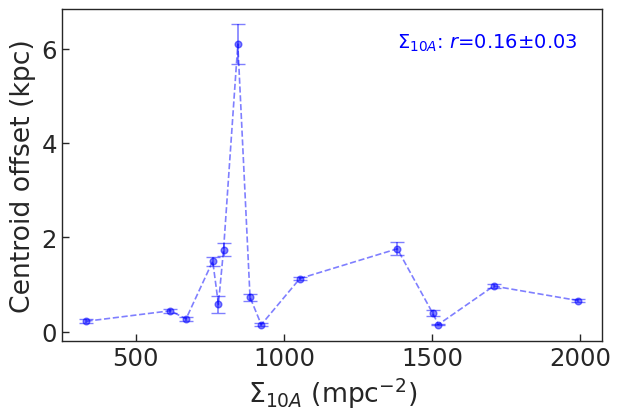

In [12]:
# fig, ax = plt.subplots(1, 1, figsize=pf.get_fig_size(pf.mnras_colwidth * 2))
fig, ax = plt.subplots(1, 1, figsize=pf.get_fig_size(pf.mnras_textwidth))
errbar_plot(
    Sigma_10a_sdset,
    center_diffs_10a,
    sigma_center_diffs_10a,
    ["S_10a", "centroid_offset1"],
    r_centroid_off_Sigma_10a,
    ax,
    "blue",
)

#fig.tight_layout()
plt.xlabel("$\Sigma_{10A}$ (mpc$^{-2})$")
plt.ylabel("Centroid offset (kpc)")
plt.show()
fig.savefig("centroid_offset_vs_Sigma_10A.pdf", bbox_inches="tight")

## Centroid offset vs. (Sigma_10 from Method A to D).

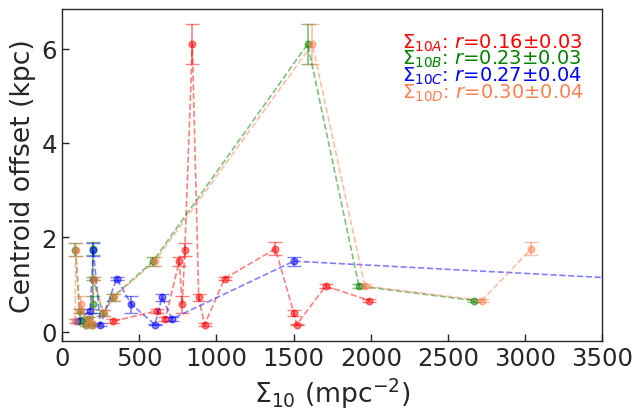

In [13]:
fig, ax = plt.subplots(1, 1, figsize=pf.get_fig_size(pf.mnras_textwidth))

# fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)


errbar_plot(
    Sigma_10a_sdset,
    center_diffs_10a,
    sigma_center_diffs_10a,
    ["S_10a", "centroid_offset2"],
    r_centroid_off_Sigma_10a,
    ax,
    "red",
)
errbar_plot(
    Sigma_10b_sdset,
    center_diffs_10b,
    sigma_center_diffs_10b,
    ["S_10b", "centroid_offset2"],
    r_centroid_off_Sigma_10b,
    ax,
    "green",
)
errbar_plot(
    Sigma_10c_sdset,
    center_diffs_10c,
    sigma_center_diffs_10c,
    ["S_10c", "centroid_offset2"],
    r_centroid_off_Sigma_10c,
    ax,
    "blue",
)
errbar_plot(
    Sigma_10d_sdset,
    center_diffs_10d,
    sigma_center_diffs_10d,
    ["S_10d", "centroid_offset2"],
    r_centroid_off_Sigma_10d,
    ax,
    "coral",
)

ax.set_xlim(0, 3500)
#fig.tight_layout()
plt.xlabel("$\Sigma_{10}$ (mpc$^{-2})$")
plt.ylabel("Centroid offset (kpc)")
plt.show()
fig.savefig("centroid_offset_vs_Sigma_10AtoD.pdf", bbox_inches="tight")

## Centroid offset vs. Sigmas from Method A

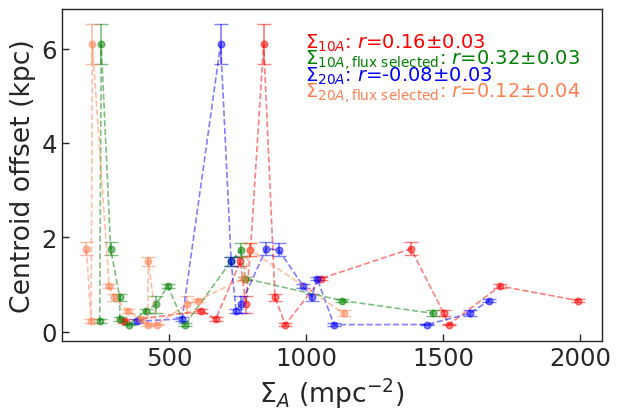

In [14]:
fig, ax = plt.subplots(1, 1, figsize=pf.get_fig_size(pf.mnras_textwidth))

# fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)


errbar_plot(
    Sigma_10a_sdset,
    center_diffs_10a,
    sigma_center_diffs_10a,
    ["S_10a", "centroid_offset3"],
    r_centroid_off_Sigma_10a,
    ax,
    "red",
)
errbar_plot(
    Sigma_10afs_sdset,
    center_diffs_10afs,
    sigma_center_diffs_10afs,
    ["S_10afs", "centroid_offset3"],
    r_centroid_off_Sigma_10afs,
    ax,
    "green",
)
errbar_plot(
    Sigma_20a_sdset,
    center_diffs_20a,
    sigma_center_diffs_20a,
    ["S_20a", "centroid_offset3"],
    r_centroid_off_Sigma_20a,
    ax,
    "blue",
)
errbar_plot(
    Sigma_20afs_sdset,
    center_diffs_20afs,
    sigma_center_diffs_20afs,
    ["S_20afs", "centroid_offset3"],
    r_centroid_off_Sigma_20afs,
    ax,
    "coral",
)

#fig.tight_layout()
plt.xlabel("$\Sigma_{A}$ (mpc$^{-2})$")
plt.ylabel("Centroid offset (kpc)")
plt.show()
fig.savefig("centroid_offset_vs_Sigma_all.pdf", bbox_inches="tight")

# Position-angle offset vs. $\Sigma$ cases

## Position-angle offset vs. Sigma_10 from Method A

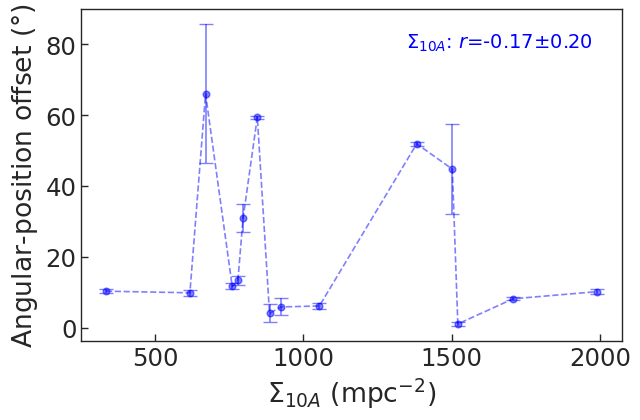

In [15]:
fig, ax = plt.subplots(1, 1, figsize=pf.get_fig_size(pf.mnras_textwidth))

errbar_plot(
    Sigma_10a_sdset,
    dphis_10a,
    sigma_dphis_10a,
    ["S_10a", "position_angle_offset4"],
    r_dphi_Sigma_10a,
    ax,
    "blue",
)

#fig.tight_layout()
plt.xlabel("$\Sigma_{10A}$ (mpc$^{-2})$")
plt.ylabel("Angular-position offset ($\degree$)")
plt.show()
fig.savefig(
    "position_angle_offset_vs_Sigma_10A.pdf", bbox_inches="tight"
)

## Position-angle offset vs. (Sigma_10 from Method A to D)

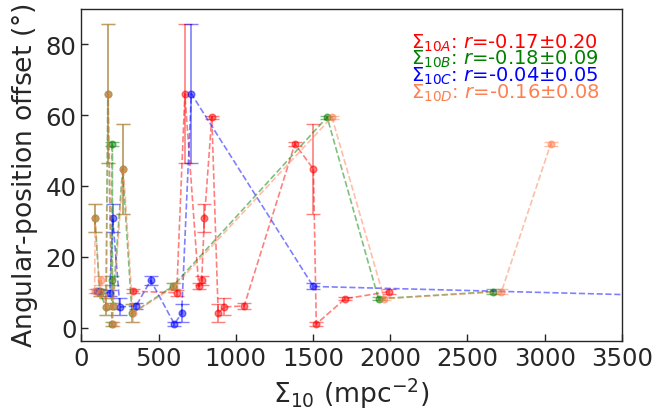

In [16]:
fig, ax = plt.subplots(1, 1, figsize=pf.get_fig_size(pf.mnras_textwidth))

# fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)


errbar_plot(
    Sigma_10a_sdset,
    dphis_10a,
    sigma_dphis_10a,
    ["S_10a", "position_angle_offset5"],
    r_dphi_Sigma_10a,
    ax,
    "red",
)
errbar_plot(
    Sigma_10b_sdset,
    dphis_10b,
    sigma_dphis_10b,
    ["S_10b", "position_angle_offset5"],
    r_dphi_Sigma_10b,
    ax,
    "green",
)
errbar_plot(
    Sigma_10c_sdset,
    dphis_10c,
    sigma_dphis_10c,
    ["S_10c", "position_angle_offset5"],
    r_dphi_Sigma_10c,
    ax,
    "blue",
)
errbar_plot(
    Sigma_10d_sdset,
    dphis_10d,
    sigma_dphis_10d,
    ["S_10d", "position_angle_offset5"],
    r_dphi_Sigma_10d,
    ax,
    "coral",
)
ax.set_xlim(0, 3500)
#fig.tight_layout()
plt.xlabel("$\Sigma_{10}$ (mpc$^{-2})$")
plt.ylabel("Angular-position offset ($\degree$)")
plt.show()
fig.savefig(
    "position_angle_offset_vs_Sigma_10AtoD.pdf", bbox_inches="tight"
)

## Position-angle offset vs. Sigmas from Method A


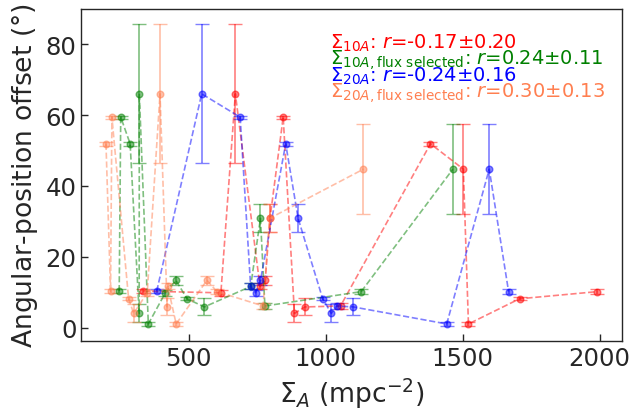

In [17]:
#### plot for all the four cases of position angle offset vs. Sigmas

fig, ax = plt.subplots(1, 1, figsize=pf.get_fig_size(pf.mnras_textwidth))

# fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)


errbar_plot(
    Sigma_10a_sdset,
    dphis_10a,
    sigma_dphis_10a,
    ["S_10a", "position_angle_offset6"],
    r_dphi_Sigma_10a,
    ax,
    "red",
)
errbar_plot(
    Sigma_10afs_sdset,
    dphis_10afs,
    sigma_dphis_10afs,
    ["S_10afs", "position_angle_offset6"],
    r_dphi_Sigma_10afs,
    ax,
    "green",
)
errbar_plot(
    Sigma_20a_sdset,
    dphis_20a,
    sigma_dphis_20a,
    ["S_20a", "position_angle_offset6"],
    r_dphi_Sigma_20a,
    ax,
    "blue",
)
errbar_plot(
    Sigma_20afs_sdset,
    dphis_20afs,
    sigma_dphis_20afs,
    ["S_20afs", "position_angle_offset6"],
    r_dphi_Sigma_20afs,
    ax,
    "coral",
)

#fig.tight_layout()
plt.xlabel("$\Sigma_{A}$ (mpc$^{-2})$")
plt.ylabel("Angular-position offset ($\degree$)")
plt.show()
fig.savefig(
    "position_angle_offset_vs_Sigma_all.pdf", bbox_inches="tight"
)

## Function without connecting points

In [18]:
# Function for sampling and calculating the pearson correlation coefficients
# between two parameters


def errbar_plot_disconnected(dset1, dset2, error, param, r, ax, c):
    """
    Create scatter plot with error bars.

    :param dset1: list; dataset along the x-axis
    :param dset2: list; dataset along the y-axis
    :param error: error along the y-axis
    :param param: list of strings
    :param r: pearson-r
    :param ax: axis to plot on
    :param c: color
    :return: the plot
    """

    ax.errorbar(dset1, dset2, yerr=error, fmt="o", color=c, alpha=0.5, capsize=5)

    str = f"$r$={r[0]:.2f}$\pm${(r[1]-r[2])*.5:.2f}"

    match param:
        # For theta_E vs Sigma_10A and Gamma_shear vs Sigma_10A
        case ["S_10a", "theta_E_kpc"]:
            ax.text(
                0.52,
                0.9,
                r"$\theta_{E}$ vs. $\Sigma_{10A}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=14,
                color=c,
            )

        case ["S_10a", "gamma_shear"]:
            ax.text(
                0.46,
                0.9,
                r"$\gamma_{\rm shear}$ vs. $\Sigma_{10A}$: " + str,
                horizontalalignment="left",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=14,
                color=c,
            )

    ax.tick_params(direction="in")

## Einstein Radius vs. Sigma_10 from Method A

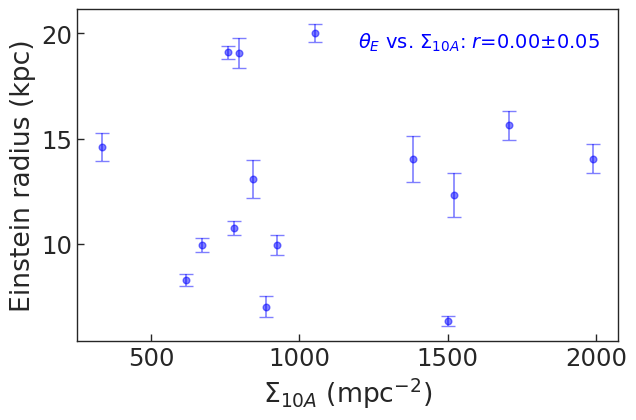

In [19]:
fig, ax = plt.subplots(1, 1, figsize=pf.get_fig_size(pf.mnras_textwidth))

errbar_plot_disconnected(
    Sigma_10a_sdset,
    theta_E_m_10a,
    theta_E_u_10a,
    ["S_10a", "theta_E_kpc"],
    r_theta_E_Sigma_10a,
    ax,
    "blue",
)

#fig.tight_layout()
plt.xlabel("$\Sigma_{10A}$ (mpc$^{-2})$")
plt.ylabel("Einstein radius (kpc)")
plt.show()
fig.savefig("einstein_radius_vs_Sigma_10A.pdf", bbox_inches="tight")

## Gamma Shear vs. Sigma_10 from Method A

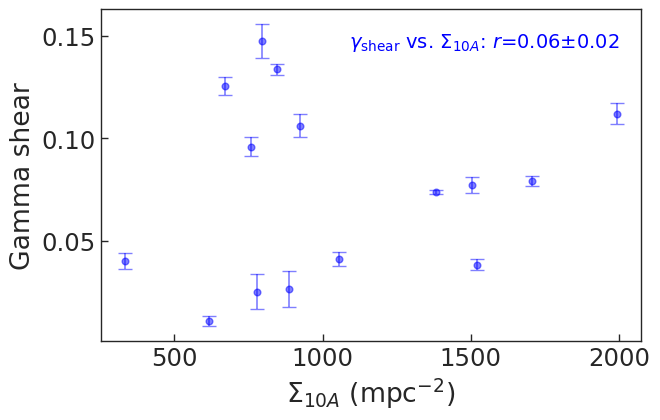

In [20]:
fig, ax = plt.subplots(1, 1, figsize=pf.get_fig_size(pf.mnras_textwidth))

errbar_plot_disconnected(
    Sigma_10a_sdset,
    gamma_shear_m_10a,
    gamma_shear_u_10a,
    ["S_10a", "gamma_shear"],
    r_gamma_shear_Sigma_10a,
    ax,
    "blue",
)

#fig.tight_layout()
plt.xlabel("$\Sigma_{10A}$ (mpc$^{-2})$")
plt.ylabel("Gamma shear")
plt.show()
fig.savefig("gamma_shear_vs_Sigma_10A.pdf", bbox_inches="tight")